## 02 CNN Classification
Dataset reference: [Medical Segmentation Decathlon](http://medicaldecathlon.com/)

## 0\. Change to GPU
開啟此 notebook 後，請先至左上角「執行階段」內點選
「變更執行階段類型」，並將硬體加速器改為「GPU」

## 1\. Prepare the Enviornment

In [ ]:
import os
import numpy as np
import nibabel as nib
from random import shuffle
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from random import randint
from scipy.ndimage import zoom
from matplotlib import pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, roc_curve, auc

## 2\. Download the Dataset

請確保liver_classification.zip捷徑已存在個人Google Drive根目錄

In [ ]:

from google.colab import drive


drive.mount('/content/drive/')

# 將工作目錄切換到要存放liver_classification教材的目錄底下。
os.chdir('/content')

# 解壓縮到content/liver_classification
if not os.path.exists(r"/content/liver_classification"):
    !unzip /content/drive/MyDrive/liver_classification.zip


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 3\. Import and View the Data
Let's check the dataset.

In [ ]:
# Set the path
data_dir = '/content/liver_classification'
image_dir = os.path.join(data_dir, 'crop_image')
label_dir = os.path.join(data_dir, 'crop_label')

In [ ]:
# Check how much data we have
print("Number of images:", len(os.listdir(image_dir)))
print("Number of labels:", len(os.listdir(label_dir)))

Number of images: 130
Number of labels: 130


We have 130 pairs of CT images and labels.\
Then, we need to separate the 130 data into training, validation, and testing sets. \
You can decide the amount of each set.

In [ ]:
# Separate data into training, validation, and testing set with ratio [0.6, 0.2, 0.2]
total_filelist = os.listdir(image_dir)
shuffle(total_filelist)

############### change here #################
train_n = 78
valid_n = 26
test_n = 26
############### change here #################

train_list = total_filelist[:train_n]
valid_list = total_filelist[train_n : train_n+valid_n]
test_list = total_filelist[train_n + valid_n : train_n + valid_n + test_n]
print("{} data for training, list: {}".format(len(train_list), train_list))
print("{} data for validation, list: {}".format(len(valid_list), valid_list))
print("{} data for testing, list: {}".format(len(test_list), test_list))

78 data for training, list: ['liver_76.nii.gz', 'liver_114.nii.gz', 'liver_30.nii.gz', 'liver_50.nii.gz', 'liver_26.nii.gz', 'liver_14.nii.gz', 'liver_57.nii.gz', 'liver_48.nii.gz', 'liver_119.nii.gz', 'liver_27.nii.gz', 'liver_10.nii.gz', 'liver_105.nii.gz', 'liver_71.nii.gz', 'liver_95.nii.gz', 'liver_86.nii.gz', 'liver_11.nii.gz', 'liver_19.nii.gz', 'liver_22.nii.gz', 'liver_3.nii.gz', 'liver_127.nii.gz', 'liver_35.nii.gz', 'liver_62.nii.gz', 'liver_102.nii.gz', 'liver_64.nii.gz', 'liver_123.nii.gz', 'liver_34.nii.gz', 'liver_85.nii.gz', 'liver_82.nii.gz', 'liver_67.nii.gz', 'liver_115.nii.gz', 'liver_88.nii.gz', 'liver_112.nii.gz', 'liver_125.nii.gz', 'liver_2.nii.gz', 'liver_130.nii.gz', 'liver_100.nii.gz', 'liver_56.nii.gz', 'liver_124.nii.gz', 'liver_74.nii.gz', 'liver_109.nii.gz', 'liver_7.nii.gz', 'liver_90.nii.gz', 'liver_110.nii.gz', 'liver_61.nii.gz', 'liver_101.nii.gz', 'liver_41.nii.gz', 'liver_5.nii.gz', 'liver_44.nii.gz', 'liver_108.nii.gz', 'liver_33.nii.gz', 'liver_17

After we separate the data, we have to load the data and perform preprocessing in order to


1.   adjust the format of data to fit into the model
2.   perform image processing to avoid useless information

Below are the two basic functions for image preprocessing and data loading


In [ ]:
# function of image preprocessing
def preprocessing(image, label, output_shape=(224, 224), method='method_1'):
  # Method 1 & 2 - resample the whole image (make all images to the assigned size)
  if method in ['method_1', 'method_2']:
    resize_factor_x = output_shape[0] / np.shape(image)[0]
    resize_factor_y = output_shape[1] / np.shape(image)[1]
    image = zoom(image, (resize_factor_x, resize_factor_y), order=0, mode='nearest')
    label = zoom(label, (resize_factor_x, resize_factor_y), order=0, mode='nearest')

  # Method 3 - crop the image by the information of segmentation label (set background to 0)
  elif method == 'method_3':
    width, length = output_shape
    center_x = (np.max(np.where(label != 0)[0]) + np.min(np.where(label != 0)[0]))/2
    center_y = (np.max(np.where(label != 0)[1]) + np.min(np.where(label != 0)[1]))/2
    center_x = np.clip(center_x, width/2, image.shape[0] - width/2)
    center_y = np.clip(center_y, length/2, image.shape[1] - length/2)
    x_min = int(center_x - width/2)
    x_max = x_min + width
    y_min = int(center_y - length/2)
    y_max = y_min + length

    # Crop the image and label
    image = image[x_min:x_max, y_min:y_max]
    label = label[x_min:x_max, y_min:y_max]

  return image, label

In [ ]:
# function of data loading
def load_data(image_dir, label_dir, file_list, output_shape=(224, 224), channel=3, method='method_1', perform_mask=True):
  X = []
  y = []
  if method == 'method_2':
    threshold_tumor = 0.001
    threshold_liver = 0.04
  else:
    threshold_tumor = 0.002
    threshold_liver = 0.08

  for filename in tqdm(file_list):
    ori_image = nib.load(os.path.join(image_dir, filename)).get_fdata()
    ori_label = nib.load(os.path.join(label_dir, filename)).get_fdata()
    if method == 'method_1':
      x_min = np.min(np.where(ori_label != 0)[0])
      x_max = np.max(np.where(ori_label != 0)[0])
      y_min = np.min(np.where(ori_label != 0)[1])
      y_max = np.max(np.where(ori_label != 0)[1])
      ori_image = ori_image[x_min:x_max, y_min:y_max, :]
      ori_label = ori_label[x_min:x_max, y_min:y_max, :]
    for idx in range(ori_image.shape[2]):
      if not np.max(ori_label[:, :, idx]) == 0:
        image_2d, label_2d = preprocessing(ori_image[:, :, idx], ori_label[:, :, idx], output_shape=output_shape, method=method)
        # Preprocessing - windowing
        image_2d = np.clip(image_2d, -50, 200)
        # Preprocessing - normalization
        image_2d = (image_2d - np.min(image_2d))/(np.max(image_2d) - np.min(image_2d))
        # Preprocessing - masking
        if perform_mask:
          image_2d[np.where(label_2d == 0)] = 0
        if np.max(label_2d) == 2 and np.count_nonzero(label_2d == 1) > output_shape[0]**2*threshold_tumor:
          X.append(image_2d)
          y.append(1)
        elif np.max(label_2d) == 1 and np.count_nonzero(label_2d == 1) > output_shape[0]**2*threshold_liver:
          X.append(image_2d)
          y.append(0)

  # X = np.expand_dims(np.array(X), -1)
  X = np.array(X)
  stacked_X = np.stack((X,)*channel, axis=-1)
  print("We got {} 2D images with {}".format(len(y), Counter(y)))
  y = np.array(y)
  print("Done loading data with X shape = {}, y shape = {}".format(stacked_X.shape, y.shape))

  return stacked_X, y

We provide three image processing methods. \
Also, you can try to apply masking on the image or not.

In [ ]:
# Load data and perform image processing

############### change here #################
method = 'method_2'
perform_mask = True
############### change here #################

train_X, train_y = load_data(image_dir, label_dir, train_list, method=method, perform_mask=perform_mask)
valid_X, valid_y = load_data(image_dir, label_dir, valid_list, method=method, perform_mask=perform_mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



We got 1480 2D images with Counter({0: 812, 1: 668})
Done loading data with X shape = (1480, 224, 224, 3), y shape = (1480,)



We got 532 2D images with Counter({1: 314, 0: 218})
Done loading data with X shape = (532, 224, 224, 3), y shape = (532,)


After loading the data, let's have a look at what `train_X`, `train_y`, `valid_X`, `valid_y` we got.

In [ ]:
# function of plotting data randomly
def plot_image(X, y, row, col):
  ax = []
  fig = plt.figure(figsize=(3*col, 3*row))


  for i in range(row*col):
    value = randint(0, X.shape[0]-1)
    image_plot = X[value, :, :, 0]
    ax.append(fig.add_subplot(row, col, i+1))
    ax[i].set_title("Label: {}".format(y[value]))
    plt.axis('off')
    plt.imshow(image_plot, cmap='gray')
  plt.show()

We can randomly pick some examples from training or validation sets to see the images.\
You can change how many images to show at each row or column run the code repeatly.

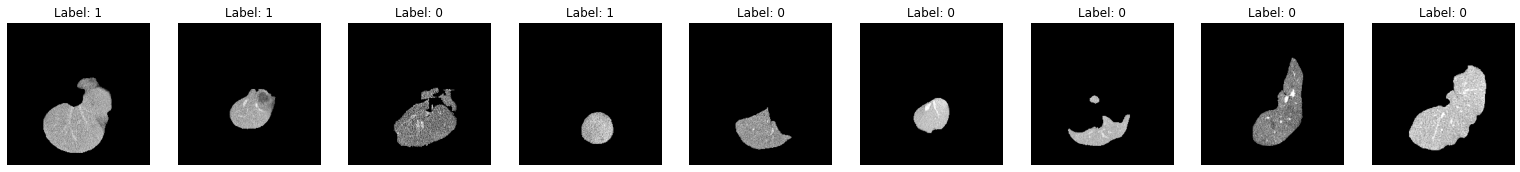

In [ ]:
############### change here #################
row = 1
col = 9
############### change here #################

plot_image(train_X, train_y, row, col)

## 4\. Build the Model
We finish preparing the data! \
It's time to build a CNN model for classification if the CT iamge contains a liver tumor or not.\
Here we use MobileNet provided by Keras Applications because this may be the fastest model. \
You can also visit [Keras Applications](https://keras.io/api/applications/) to try different model.

In [ ]:
from tensorflow.keras.applications import MobileNet

In [ ]:
# Load the model and add layers for binary classification output
base_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000
)


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(
      optimizer=keras.optimizers.Adam(1e-4),
      loss="binary_crossentropy",
      metrics=["accuracy"],
)

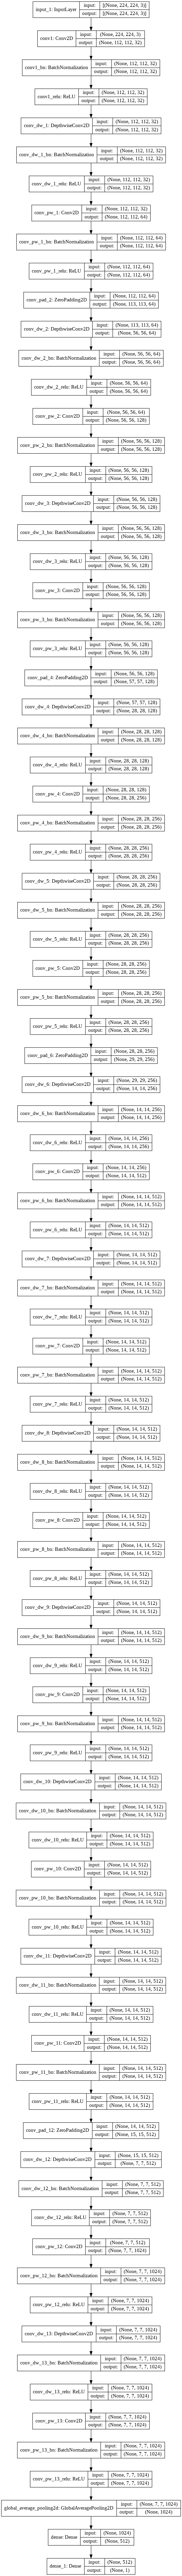

In [ ]:
# [optional] Plot the model (method 1)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# [optional] Plot the model (method 2)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

We start training the model here. \
Please notice that this might take a while. You can also adjust the number of epochs.


In [ ]:
############### change here #################
epochs = 10
############### change here #################

history = model.fit(train_X,
           train_y,
           epochs=epochs,
           batch_size=32,
           validation_data=(valid_X, valid_y))

Epoch 1/10
47/47 [==============================] - 19s 204ms/step - loss: 0.6146 - accuracy: 0.6587 - val_loss: 0.6272 - val_accuracy: 0.6203
Epoch 2/10
47/47 [==============================] - 9s 183ms/step - loss: 0.3764 - accuracy: 0.8364 - val_loss: 0.6030 - val_accuracy: 0.6635
Epoch 3/10
47/47 [==============================] - 9s 187ms/step - loss: 0.1582 - accuracy: 0.9596 - val_loss: 0.6124 - val_accuracy: 0.6711
Epoch 4/10
47/47 [==============================] - 9s 185ms/step - loss: 0.0949 - accuracy: 0.9722 - val_loss: 0.8935 - val_accuracy: 0.6447
Epoch 5/10
47/47 [==============================] - 9s 186ms/step - loss: 0.0439 - accuracy: 0.9902 - val_loss: 0.7200 - val_accuracy: 0.7124
Epoch 6/10
47/47 [==============================] - 9s 187ms/step - loss: 0.0235 - accuracy: 0.9947 - val_loss: 1.0942 - val_accuracy: 0.6391
Epoch 7/10
47/47 [==============================] - 9s 189ms/step - loss: 0.0098 - accuracy: 0.9998 - val_loss: 0.9053 - val_accuracy: 0.6692
Epoch

Let's take a look at the changes of  loss and accuracy on training and validation data during training.

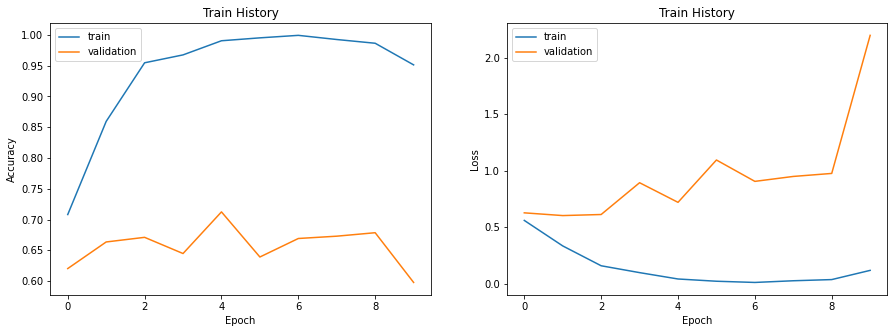

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

## 5\. Evaluate the Test Data
We've done training the model. \
Now it's time to see how the model perform on testing data.\
Firstly, let's load the testing data using the same method when we load the training and validation data.

In [ ]:
test_X, test_y = load_data(image_dir, label_dir, test_list, method=method, perform_mask=perform_mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



We got 530 2D images with Counter({1: 298, 0: 232})
Done loading data with X shape = (530, 224, 224, 3), y shape = (530,)


Here we perform the trained mdoel on the test data.

In [ ]:
predict_y = model.predict(test_X)

Then, we can see the classification results.

Text(0.5, 0, 'False Positive Rate')

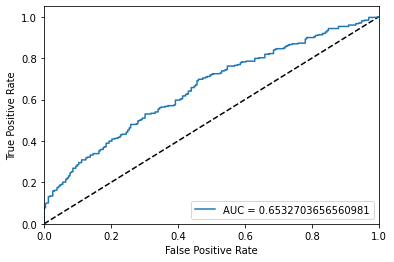

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, _ = roc_curve(test_y, predict_y)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))

plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We now turn the result into binary result, and make the comparison on the groundtruths by the confusion matrix.

In [ ]:
predict_y[predict_y >= 0.5] = 1
predict_y[predict_y < 0.5] = 0

print(confusion_matrix(test_y, predict_y, labels=[1, 0]))

[[297   1]
 [228   4]]


Then, we can check the sensitivity and specificity.

In [ ]:
TP = confusion_matrix(test_y, predict_y, labels=[1, 0])[0, 0]
FP = confusion_matrix(test_y, predict_y, labels=[1, 0])[1, 0]
FN = confusion_matrix(test_y, predict_y, labels=[1, 0])[0, 1]
TN = confusion_matrix(test_y, predict_y, labels=[1, 0])[1, 1]
print("True positive: {}".format(TP))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN))
print("True negative: {}".format(TN))


############### your code here #################
sensitivity = TP/(TP+FN)
specificity = TN/(TN+FN)
############### your code here #################

print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

True positive: 297
False positive: 228
False negative: 1
True negative: 4
Sensitivity: 0.9966442953020134
Specificity: 0.8
